In [1]:
%load_ext autoreload
%autoreload 2

import os 
import pyreadr
import numpy as np
import pyreadr
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
import butterfly.album
import butterfly.Models
from itertools import combinations 
from joblib import parallel_backend
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import r2_score
import pickle
from sklearn.model_selection import GroupKFold
from random import sample
from scipy import stats
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

Using TensorFlow backend.
/home/mxenoc/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mxenoc/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mxenoc/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mxenoc/anaconda3/lib/python3.7/site-packages/tenso

In [2]:
#Define the predictor datasets
omics = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']

In [3]:
#Import your data
#DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

In [ ]:
pixels = 128 #image size
perplexity = 75 #perplexity for the tsne
scaler = "QuantileTransformer"

albums_all_75 = []
for predictor_index in tqdm(range(len(omics))):
    
    #Get your predictor dataset
    predictors = list(omics)
    predictors.remove(omics[predictor_index])
    predictors = tuple(predictors)

    albums_all_75.append(butterfly.album.create_album(
        DF, predictors, pixels, perplexity, scaler))

In [42]:
os.chdir('/home/mxenoc/workspace/butterfly/data/pickles')
with open('albums_all_QT_75.pkl', 'wb') as f:  
    pickle.dump(albums_all_75, f)

In [43]:
RF_predictor = []
for predictor_index in range(len(omics)):
    
    #Get your predictor dataset
    DFB = DF.copy()

    unwanted = DFB.columns[DFB.columns.str.startswith(omics[predictor_index])]
    DFB.drop(unwanted, axis=1, inplace=True)
    DFB.drop(['patient_TR', 'patientID', 'trimester'], axis=1, inplace=True)
    DFB = DFB.values
    DFB = QuantileTransformer(n_quantiles=10, random_state=0).fit_transform(DFB)

    RF_predictor.append(DFB)

In [44]:
os.chdir('/home/mxenoc/workspace/butterfly/data/pickles')
with open('RF_predictor_QT.pkl', 'wb') as f:  
    pickle.dump(RF_predictor, f)

In [113]:
groups_c = []
for predictor_index in range(len(omics)):
    
    #Get your predictor dataset
    DFB = DF.copy()

    unwanted = DFB.columns[DFB.columns.str.startswith(omics[predictor_index])]
    DFB.drop(unwanted, axis=1, inplace=True)
    DFB.drop(['patient_TR', 'patientID', 'trimester'], axis=1, inplace=True)
    DFB = pd.DataFrame(DFB.columns.values)
    DFB.columns = ['test']

    DFB['rna'] = np.where(DFB.test.str.startswith(omics[0]), 1, 0)
    DFB['plasma_l'] = np.where(DFB.test.str.startswith(omics[1]), 2, 0)
    DFB['serum_l'] = np.where(DFB.test.str.startswith(omics[2]), 3, 0)
    DFB['microb'] = np.where(DFB.test.str.startswith(omics[3]), 4, 0)
    DFB['immune'] = np.where(DFB.test.str.startswith(omics[4]), 5, 0)
    DFB['metabol'] = np.where(DFB.test.str.startswith(omics[5]), 6, 0)
    DFB['plasma_s'] = np.where(DFB.test.str.startswith(omics[6]), 7, 0)

    DFB = DFB.drop(['test'], axis=1)
    DFB['group_cols']= DFB.sum(axis=1)

    groups_c.append(DFB['group_cols'])

In [117]:
os.chdir('/home/mxenoc/workspace/butterfly/data/pickles')
with open('groups_c.pkl', 'wb') as f:  
    pickle.dump(groups_c, f)

In [45]:
pixels = 40 #image size
perplexity = 25 #perplexity for the tsne
scaler = "QuantileTransformer"

albums = Parallel(n_jobs=len(omics))(delayed(butterfly.album.create_album)
                                                    (DF, omics[al], pixels, perplexity, scaler)
                                                    for al in range(len(omics)))

In [46]:
os.chdir('/home/mxenoc/workspace/butterfly/data/pickles')
with open('albums_QT.pkl', 'wb') as f:  
    pickle.dump(albums, f)

In [10]:
n_samples = 10 #features to sample from each dataset

#Define the predictor datasets
omics = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']

#Import your data
#DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

responses = []
for predictor_index in range(len(omics)):
    
    #Get your response dataset
    DFB = DF.copy()
    response = sample([col for col in DFB if col.startswith(omics[predictor_index])], n_samples)
    responses.append(response)

In [11]:
os.chdir('/home/mxenoc/workspace/butterfly/data/pickles')
with open('responses_10.pkl', 'wb') as f:  
    pickle.dump(responses, f)

In [71]:
os.chdir('/home/mxenoc/workspace/butterfly/src/butterfly')

In [72]:
with open('albums.pkl', 'rb') as f:
    albums = pickle.load(f)

In [23]:
pixels = 40 #image size
perplexity = 25 #perplexity for the tsne
scaler = "Standard"
al = 0

albums = butterfly.album.create_album(DF, omics[al], pixels, perplexity, scaler)

In [73]:
pic = albums[5][5]

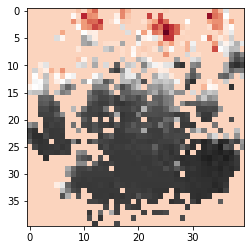

In [74]:
plot_im = plt.imshow(pic, cmap = 'RdGy')

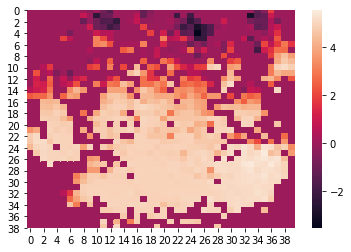

In [89]:
import seaborn as sns
sns.heatmap(pic)